In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
test = pd.read_csv('input/2021spring-cs145-ucla-covid19-prediction/test.csv', index_col=0)
train_trendency = pd.read_csv('input/2021spring-cs145-ucla-covid19-prediction/train_trendency.csv', index_col=0)
train_vaccine = pd.read_csv('input/2021spring-cs145-ucla-covid19-prediction/train_vaccine.csv')
submission = pd.read_csv('input/2021spring-cs145-ucla-covid19-prediction/submission.csv')

In [3]:
train_trendency.head()

,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate
0,Alabama,01-12-2021,407848,5573,211684.0,190591.0,8318.021857,1981019.0,1.366440,40402.697430
1,Alaska,01-12-2021,50544,225,7165.0,43132.0,6906.205360,1357708.0,0.445351,185594.597735
2,Arizona,01-12-2021,636100,10482,86757.0,538861.0,8739.177523,5742443.0,1.647854,42806.225328
3,Arkansas,01-12-2021,259553,4121,229700.0,25732.0,8600.724235,2208736.0,1.587730,73190.174047
4,California,01-12-2021,2832085,31345,NaN,2773506.0,7098.216165,36508384.0,1.110900,92397.696784


In [4]:
train_trendency.isnull().any()

Province_State         False
Date                   False
Confirmed              False
Deaths                 False
Recovered               True
Active                  True
Incident_Rate          False
Total_Test_Results     False
Case_Fatality_Ratio    False
Testing_Rate           False
dtype: bool

In [5]:
train_trendency['Date'] = pd.to_datetime(train_trendency['Date'])
train_trendency['State'] = train_trendency['Province_State'].astype("category")
train_trendency = train_trendency.drop(columns=['Province_State'])
train_trendency = train_trendency.drop(columns=['Recovered', 'Active', 'Incident_Rate', 'Total_Test_Results', 'Case_Fatality_Ratio', 'Testing_Rate'])

In [6]:
train_trendency

,Date,Confirmed,Deaths,State
0,2021-01-12,407848,5573,Alabama
1,2021-01-12,50544,225,Alaska
2,2021-01-12,636100,10482,Arizona
3,2021-01-12,259553,4121,Arkansas
4,2021-01-12,2832085,31345,California
...,...,...,...,...
3945,2021-03-31,618976,10252,Virginia
3946,2021-03-31,364486,5247,Washington
3947,2021-03-31,141738,2676,West Virginia
3948,2021-03-31,636041,7315,Wisconsin


In [7]:
def build(train_trendency):
    train_trendency = train_trendency.copy()
    date_features = {

            "wday": "weekday",
            "week": "weekofyear",
            "month": "month",
            "quarter": "quarter",
            "mday": "day",
             "ime": "is_month_end",
             "ims": "is_month_start",
        }
    
    train_trendency = train_trendency.sort_values(by=['Date', "State"])
    
    for date_feat_name, date_feat_func in date_features.items():
         train_trendency[date_feat_name] = getattr(train_trendency["Date"].dt, date_feat_func).astype("int16")
    
    train_trendency["prev_confirmed"] = train_trendency[["State","Confirmed"]].groupby("State")["Confirmed"].shift(1)
    train_trendency["new_cases"] = train_trendency["Confirmed"] - train_trendency["prev_confirmed"] 
    train_trendency.loc[train_trendency["new_cases"] < 0, "new_cases"] = 0
    train_trendency["new_cases"] = train_trendency["new_cases"] / train_trendency["prev_confirmed"]
    confirm_saved = train_trendency[["State", "Date", "Confirmed"]]
    
    train_trendency["prev_death"] = train_trendency[["State","Deaths"]].groupby("State")["Deaths"].shift(1)
    train_trendency["new_deaths"] = train_trendency["Deaths"] - train_trendency["prev_death"]
    train_trendency.loc[train_trendency["new_deaths"] < 0, "new_deaths"] = 0
    train_trendency["new_deaths"] = train_trendency["new_deaths"] / train_trendency["prev_death"]
    death_saved = train_trendency[["State", "Date", "Deaths"]]
    
    
    lags = [7, 28]
    lag_cols = [f"cases_lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        train_trendency[lag_col] = train_trendency[["State","new_cases"]].groupby("State")["new_cases"].shift(lag)
        
    lags = [7, 28]
    lag_cols = [f"deaths_lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        train_trendency[lag_col] = train_trendency[["State","new_deaths"]].groupby("State")["new_deaths"].shift(lag)
        
    wins = [7, 28]
    for win in wins :
        train_trendency[f"rmean_{win}"] = train_trendency[["State", "prev_confirmed"]].groupby("State")["prev_confirmed"].transform(lambda x : x.rolling(win).mean())
        
    wins = [7, 28]
    for win in wins :
        train_trendency[f"rmean_death_{win}"] = train_trendency[["State", "prev_death"]].groupby("State")["prev_death"].transform(lambda x : x.rolling(win).mean())
        
    wins = [7, 28]
    lags = [7, 28]
    lag_cols = [f"cases_lag_{lag}" for lag in lags ]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            train_trendency[f"rmean_{lag}_{win}_case"] = train_trendency[["State", lag_col]].groupby("State")[lag_col].transform(lambda x : x.rolling(win).mean())
    
    wins = [7, 28]
    lags = [7, 28]
    lag_cols = [f"deaths_lag_{lag}" for lag in lags ]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            train_trendency[f"rmean_{lag}_{win}_death"] = train_trendency[["State", lag_col]].groupby("State")[lag_col].transform(lambda x : x.rolling(win).mean())
            
    train_trendency = train_trendency[~ train_trendency["new_cases"].isnull()]
    train_trendency = train_trendency.drop(columns=['prev_death', "Deaths"])
    train_trendency = train_trendency.drop(columns=['prev_confirmed', "Confirmed"])
    
    return train_trendency.copy(), confirm_saved, death_saved

In [8]:
dt, cs, ds = build(train_trendency)

<ipython-input-7-5400dff68152>:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_trendency[date_feat_name] = getattr(train_trendency["Date"].dt, date_feat_func).astype("int16")


In [9]:
dt[dt["new_deaths"] < 0]

,Date,State,wday,week,month,quarter,mday,ime,ims,new_cases,...,rmean_death_7,rmean_death_28,rmean_7_7_case,rmean_28_7_case,rmean_7_28_case,rmean_28_28_case,rmean_7_7_death,rmean_28_7_death,rmean_7_28_death,rmean_28_28_death


In [10]:
dt

,Date,State,wday,week,month,quarter,mday,ime,ims,new_cases,...,rmean_death_7,rmean_death_28,rmean_7_7_case,rmean_28_7_case,rmean_7_28_case,rmean_28_28_case,rmean_7_7_death,rmean_28_7_death,rmean_7_28_death,rmean_28_28_death
50,2021-01-13,Alabama,2,2,1,1,13,0,0,0.007716,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,2021-01-13,Alaska,2,2,1,1,13,0,0,0.005856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,2021-01-13,Arizona,2,2,1,1,13,0,0,0.008849,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,2021-01-13,Arkansas,2,2,1,1,13,0,0,0.009505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,2021-01-13,California,2,2,1,1,13,0,0,0.013424,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,2021-03-31,Virginia,2,13,3,1,31,1,0,0.001675,...,10183.000000,9956.178571,0.002426,0.002780,0.002415,0.004379,0.001114,0.025753,0.009766,0.012616
3946,2021-03-31,Washington,2,13,3,1,31,1,0,0.003444,...,5218.571429,5139.714286,0.002213,0.002390,0.002158,0.002821,0.001215,0.002886,0.002038,0.004773
3947,2021-03-31,West Virginia,2,13,3,1,31,1,0,0.002944,...,2630.571429,2504.285714,0.002583,0.002214,0.002242,0.002793,0.002987,0.001494,0.004972,0.004124
3948,2021-03-31,Wisconsin,2,13,3,1,31,1,0,0.001144,...,7274.000000,7192.500000,0.000964,0.001119,0.000978,0.001373,0.001226,0.002721,0.001658,0.003027


In [11]:
import lightgbm as lgb

In [12]:
params = {
        "objective" : "mape",
        # "metric" :"rmse",
        "learning_rate" : 0.075,
         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        # "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 5000,
    'num_leaves': 40,
    "min_data_in_leaf": 5,
    "early_stopping_round" : 100
}


In [13]:
train_trendency

,Date,Confirmed,Deaths,State
0,2021-01-12,407848,5573,Alabama
1,2021-01-12,50544,225,Alaska
2,2021-01-12,636100,10482,Arizona
3,2021-01-12,259553,4121,Arkansas
4,2021-01-12,2832085,31345,California
...,...,...,...,...
3945,2021-03-31,618976,10252,Virginia
3946,2021-03-31,364486,5247,Washington
3947,2021-03-31,141738,2676,West Virginia
3948,2021-03-31,636041,7315,Wisconsin


In [14]:
predictions = ["new_cases", "new_deaths"]
train_cols = dt.columns[~dt.columns.isin(predictions + ["Date"])]
X_train = dt[train_cols]
y_train_confirm = dt["new_cases"]
y_train_death = dt["new_deaths"]

fake_valid_inds = np.random.choice(X_train.index.values, 200, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)

train_data_confirm = lgb.Dataset(X_train.loc[train_inds] , label = y_train_confirm.loc[train_inds])
fake_valid_data_confirm = lgb.Dataset(X_train.loc[fake_valid_inds], label = y_train_confirm.loc[fake_valid_inds])

train_data_death = lgb.Dataset(X_train.loc[train_inds] , label = y_train_death.loc[train_inds])
fake_valid_data_death = lgb.Dataset(X_train.loc[fake_valid_inds], label = y_train_death.loc[fake_valid_inds])

In [15]:
X_train.columns

Index(['State', 'wday', 'week', 'month', 'quarter', 'mday', 'ime', 'ims',
       'cases_lag_7', 'cases_lag_28', 'deaths_lag_7', 'deaths_lag_28',
       'rmean_7', 'rmean_28', 'rmean_death_7', 'rmean_death_28',
       'rmean_7_7_case', 'rmean_28_7_case', 'rmean_7_28_case',
       'rmean_28_28_case', 'rmean_7_7_death', 'rmean_28_7_death',
       'rmean_7_28_death', 'rmean_28_28_death'],
      dtype='object')

In [16]:
m_lgb_confirm = lgb.train(params, train_data_confirm, valid_sets = [fake_valid_data_confirm], verbose_eval=20) 

C:\Users\Arihant\.conda\envs\ml\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Arihant\.conda\envs\ml\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Arihant\.conda\envs\ml\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\Arihant\.conda\envs\ml\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[LightGBM] [Warning] Met 'abs(label) < 1', will convert them to '1' in MAPE objective and metric
[LightG

In [17]:
m_lgb_death = lgb.train(params, train_data_death, valid_sets = [fake_valid_data_death], verbose_eval=20) 

[LightGBM] [Warning] Met 'abs(label) < 1', will convert them to '1' in MAPE objective and metric
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4191
[LightGBM] [Info] Number of data points in the train set: 3700, number of used features: 23
[LightGBM] [Info] Start training from score 0.002609
Training until validation scores don't improve for 100 rounds
[20]	valid_0's mape: 0.00224367
[40]	valid_0's mape: 0.00201292
[60]	valid_0's mape: 0.00195839
[80]	valid_0's mape: 0.00193428
[100]	valid_0's mape: 0.00193254
[120]	valid_0's mape: 0.00193729
[140]	valid_0's mape: 0.00192263
[160]	valid_0's mape: 0.00192416
[180]	valid_0's mape: 0.00192546
[200]	valid_0's mape: 0.00192333
[220]	valid_0's mape: 0.00192413
[240]	valid_0's mape: 0.00191343
[260]	valid_0's mape: 0.00190815
[280]	valid_0's mape: 0.00189839
[300]	valid_0's mape: 0.00189551
[320]	

In [18]:
train_data_death.label[train_data_death.label < 0]

array([], dtype=float32)

In [19]:
test['Date'] = pd.to_datetime(test['Date'])
test['State'] = test['Province_State'].astype("category")
test = test.drop(columns=['Province_State'])

In [20]:
(test == test.sort_values(by=['Date', "State"])).all()

Date         True
Confirmed    True
Deaths       True
State        True
dtype: bool

In [21]:
prediction = train_trendency.append(test)
dtp, csp, dsp = build(prediction)

<ipython-input-7-5400dff68152>:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_trendency[date_feat_name] = getattr(train_trendency["Date"].dt, date_feat_func).astype("int16")


In [22]:
dtp

,Date,State,wday,week,month,quarter,mday,ime,ims,new_cases,...,rmean_death_7,rmean_death_28,rmean_7_7_case,rmean_28_7_case,rmean_7_28_case,rmean_28_28_case,rmean_7_7_death,rmean_28_7_death,rmean_7_28_death,rmean_28_28_death
50,2021-01-13,Alabama,2,2,1,1,13,0,0,0.007716,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,2021-01-13,Alaska,2,2,1,1,13,0,0,0.005856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,2021-01-13,Arizona,2,2,1,1,13,0,0,0.008849,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,2021-01-13,Arkansas,2,2,1,1,13,0,0,0.009505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,2021-01-13,California,2,2,1,1,13,0,0,0.013424,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2021-04-30,Virginia,4,17,4,2,30,1,0,-0.000000,...,-1.0,-1.0,0.0,0.001607,0.000402,0.002137,0.0,0.001374,0.000343,0.003320
1496,2021-04-30,Washington,4,17,4,2,30,1,0,-0.000000,...,-1.0,-1.0,0.0,0.001905,0.000476,0.002083,0.0,0.000793,0.000198,0.001432
1497,2021-04-30,West Virginia,4,17,4,2,30,1,0,-0.000000,...,-1.0,-1.0,0.0,0.002021,0.000505,0.002285,0.0,0.002599,0.000650,0.005231
1498,2021-04-30,Wisconsin,4,17,4,2,30,1,0,-0.000000,...,-1.0,-1.0,0.0,0.000697,0.000174,0.000875,0.0,0.000863,0.000216,0.001107


In [23]:
from  datetime import datetime, timedelta

fday = datetime(2021,4, 1) 

for tdelta in range(30):
    day = fday + timedelta(days=tdelta)
    tst = dtp.loc[dtp.Date == day, train_cols]
    
    oldConfirmed = prediction.loc[prediction.Date == day - timedelta(days=1), "Confirmed"]
    predictedCases = (m_lgb_confirm.predict(tst))
    predictedCases[predictedCases < 0] = 0
    newConfirmed = oldConfirmed.values + oldConfirmed.values * predictedCases
    
    oldDeath = prediction.loc[prediction.Date == day - timedelta(days=1), "Deaths"]
    predictedDeaths = (m_lgb_death.predict(tst))
    predictedDeaths[predictedDeaths < 0] = 0
    newDeath = oldDeath.values + oldDeath.values * predictedDeaths
    
    # print(m_lgb_death.predict(tst))
    
    prediction.loc[prediction.Date == day, "Confirmed"] = newConfirmed
    prediction.loc[prediction.Date == day, "Deaths"]= newDeath
    dtp, csp, dsp = build(prediction)
    
    
    
    

<ipython-input-7-5400dff68152>:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_trendency[date_feat_name] = getattr(train_trendency["Date"].dt, date_feat_func).astype("int16")
<ipython-input-7-5400dff68152>:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_trendency[date_feat_name] = getattr(train_trendency["Date"].dt, date_feat_func).astype("int16")
<ipython-input-7-5400dff68152>:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_trendency[date_feat_name] = getattr(train_trendency["Date"].dt, date_feat_func).astype("int16")
<ipython-input-7-5400dff68152>:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_trendency[date_feat_name] = geta

In [24]:
prediction

,Date,Confirmed,Deaths,State
0,2021-01-12,4.078480e+05,5573.000000,Alabama
1,2021-01-12,5.054400e+04,225.000000,Alaska
2,2021-01-12,6.361000e+05,10482.000000,Arizona
3,2021-01-12,2.595530e+05,4121.000000,Arkansas
4,2021-01-12,2.832085e+06,31345.000000,California
...,...,...,...,...
1495,2021-04-30,6.631889e+05,10819.193918,Virginia
1496,2021-04-30,4.064792e+05,5441.310241,Washington
1497,2021-04-30,1.530620e+05,2825.132489,West Virginia
1498,2021-04-30,6.604313e+05,7462.431666,Wisconsin


<ipython-input-25-250a0c9b8d9a>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


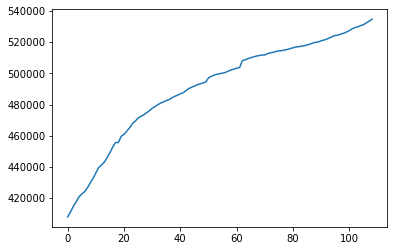

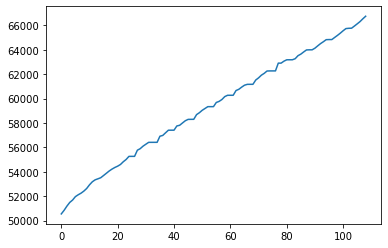

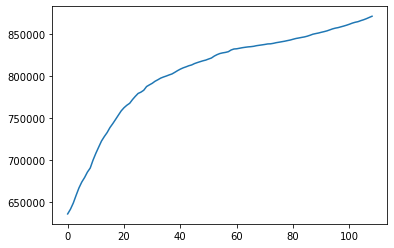

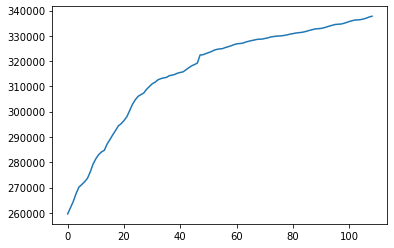

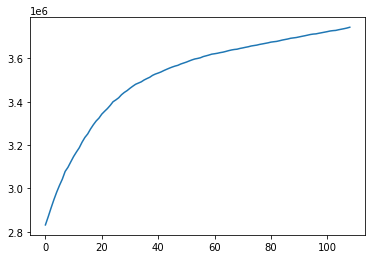

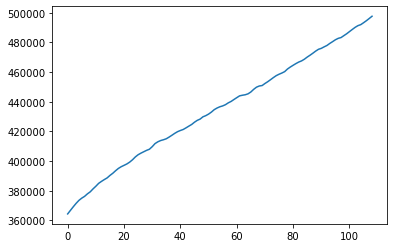

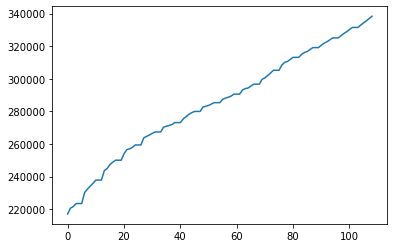

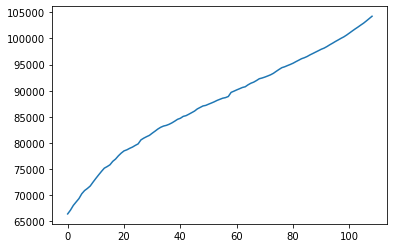

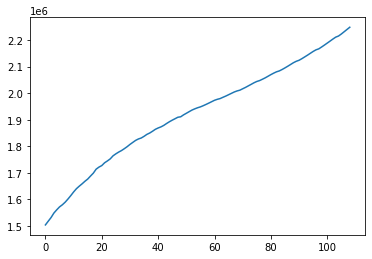

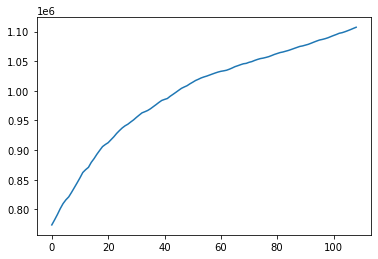

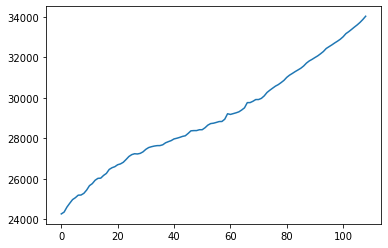

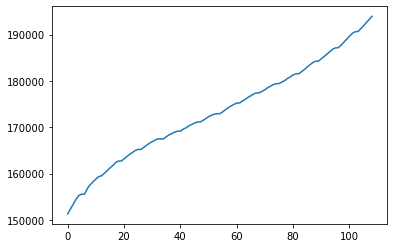

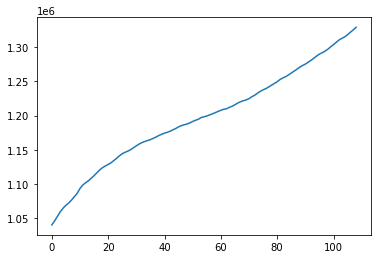

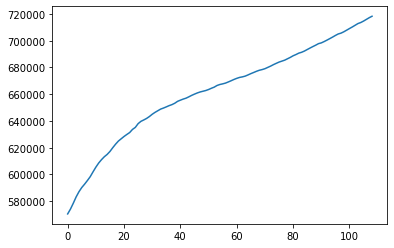

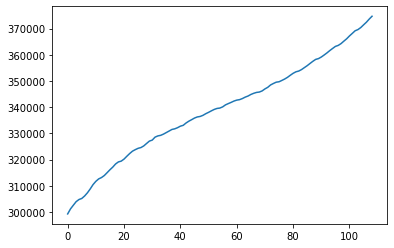

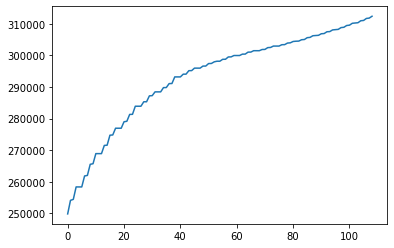

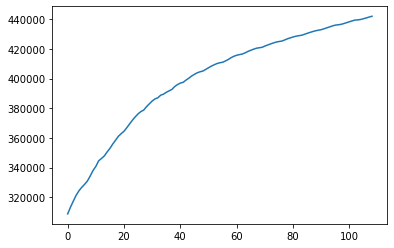

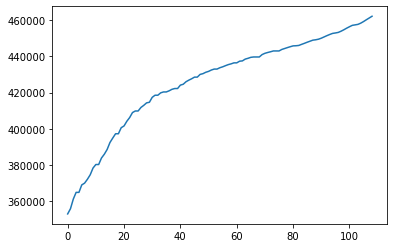

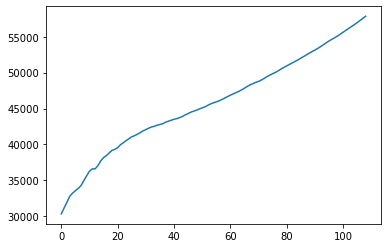

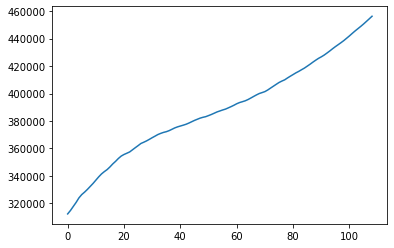

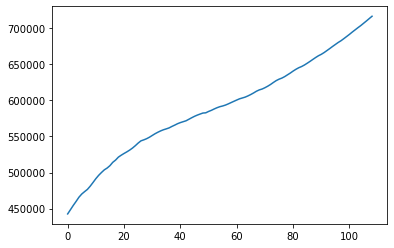

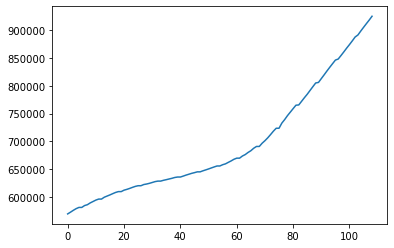

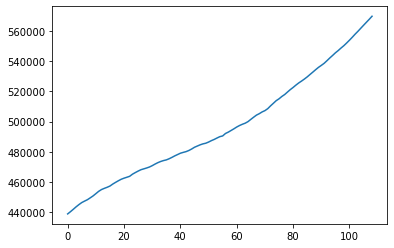

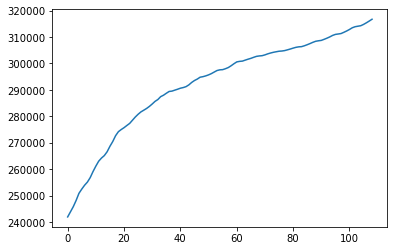

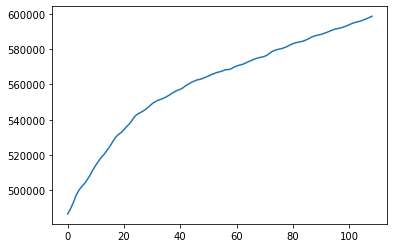

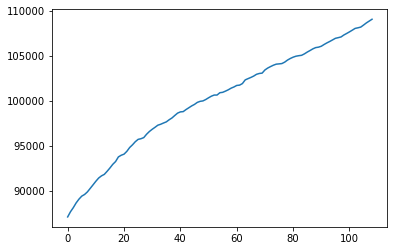

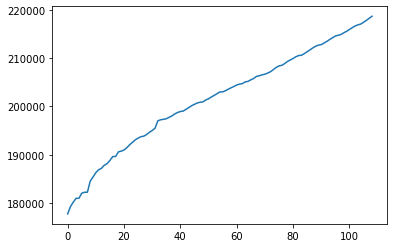

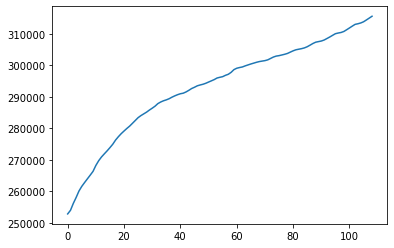

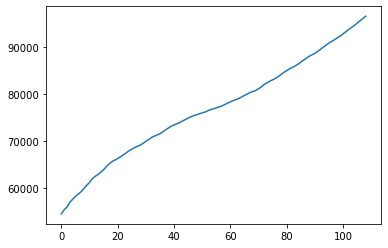

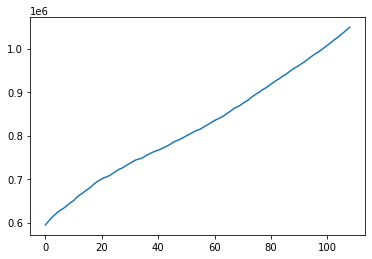

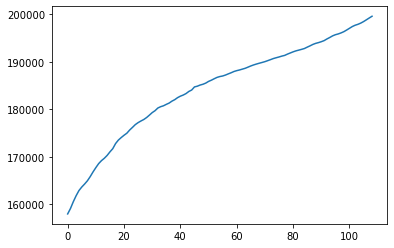

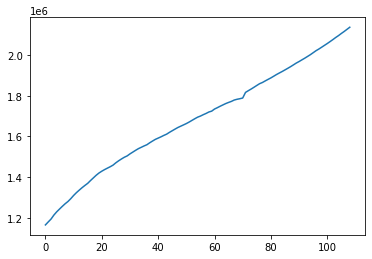

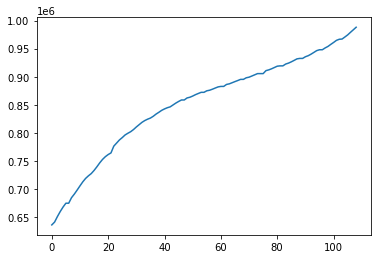

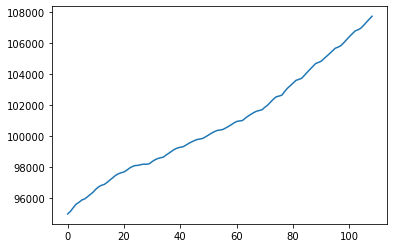

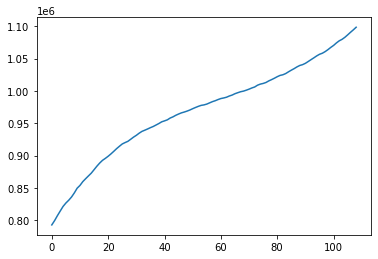

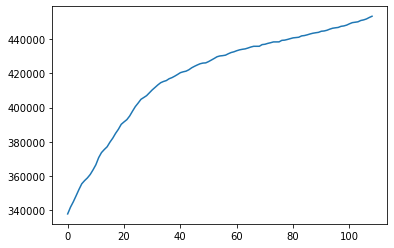

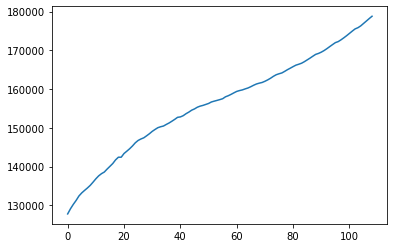

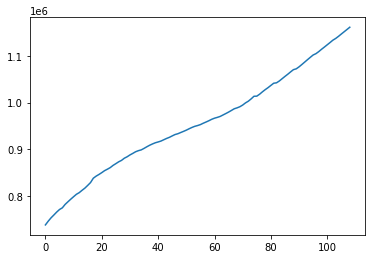

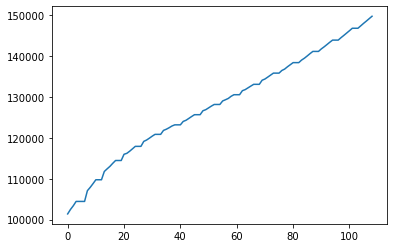

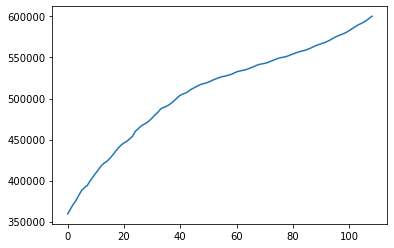

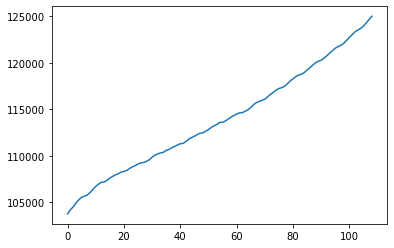

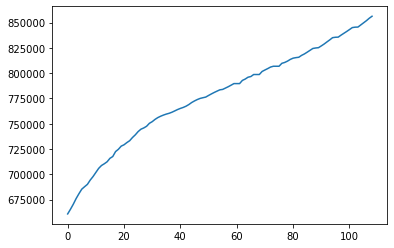

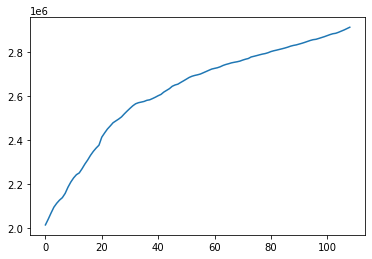

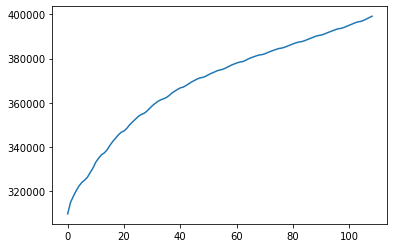

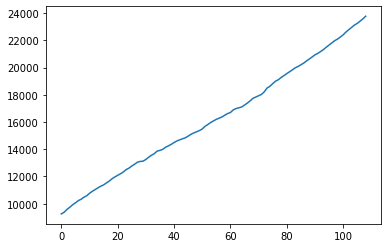

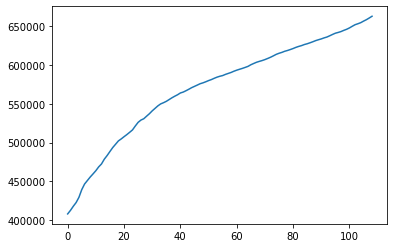

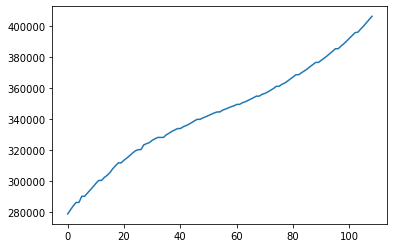

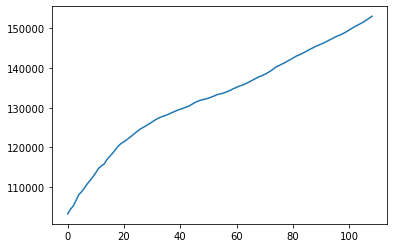

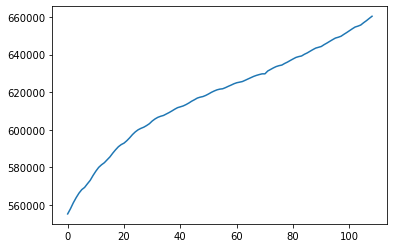

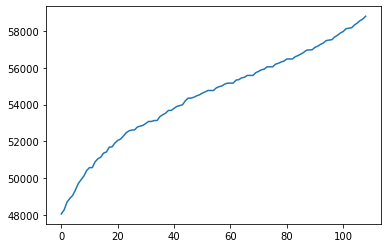

In [25]:
import matplotlib.pyplot as plt

for state in prediction["State"].cat.categories:
    values = prediction.loc[prediction.State == state, "Confirmed"].values
    plt.figure()
    plt.plot(values)

<ipython-input-26-1b95d1af365c>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


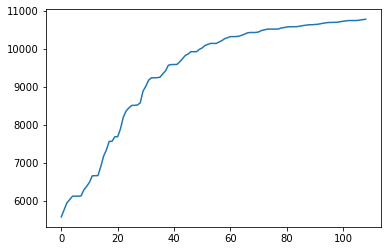

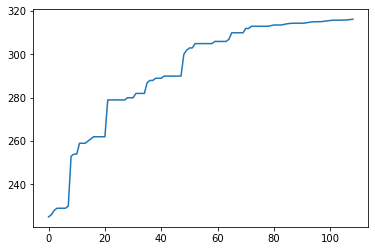

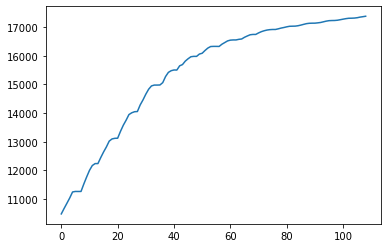

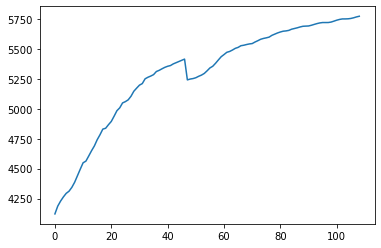

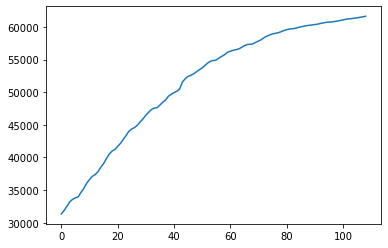

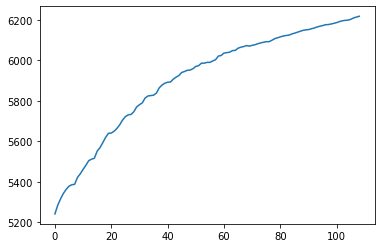

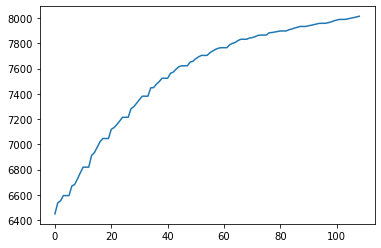

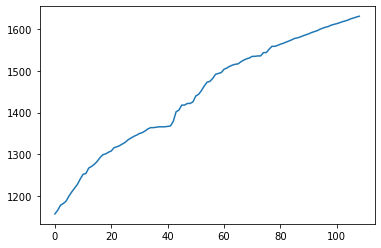

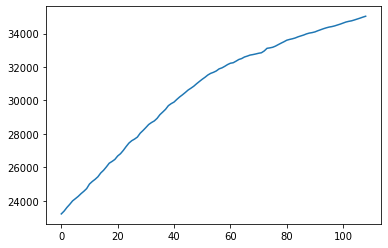

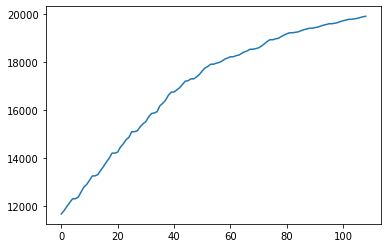

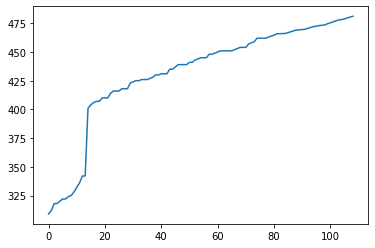

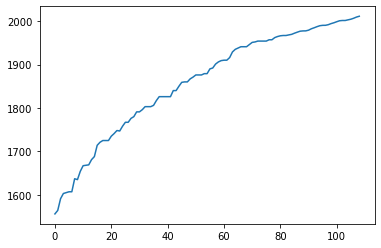

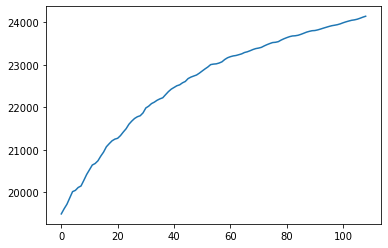

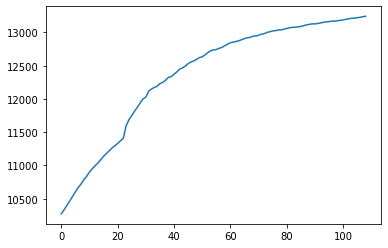

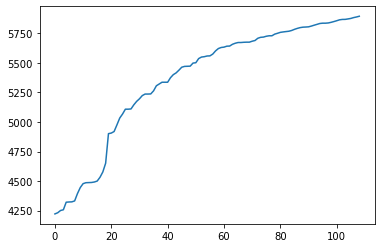

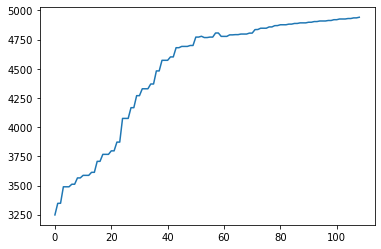

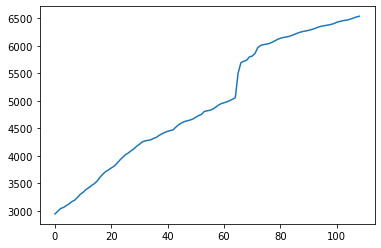

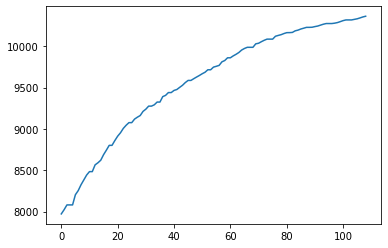

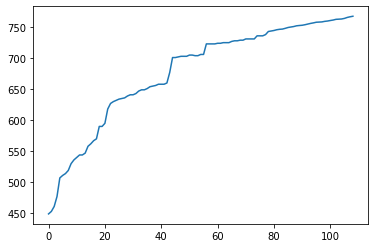

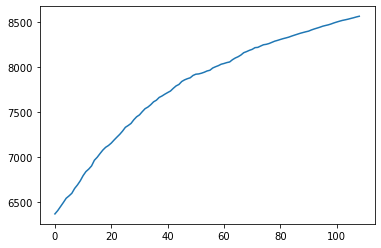

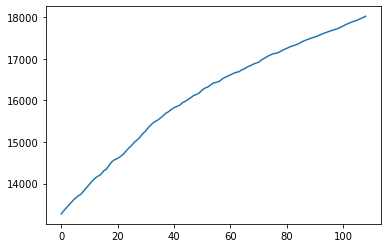

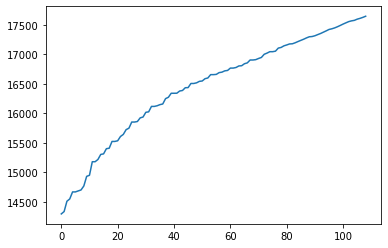

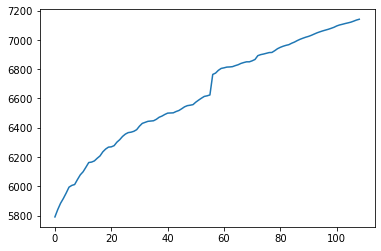

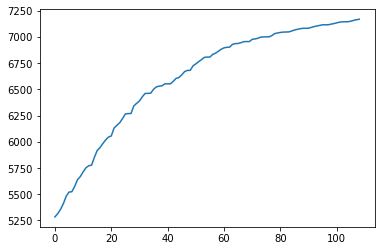

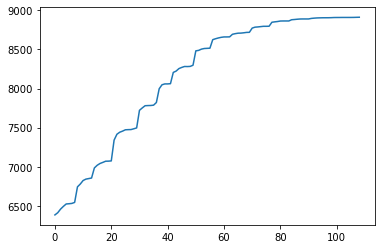

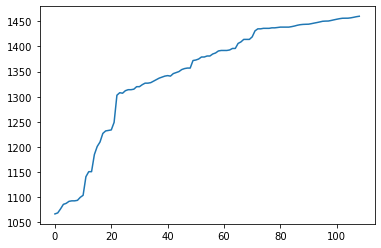

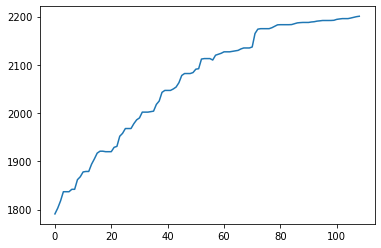

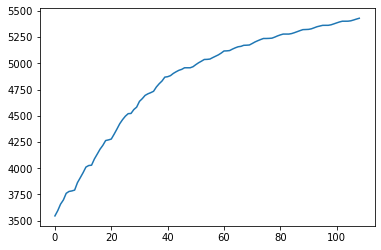

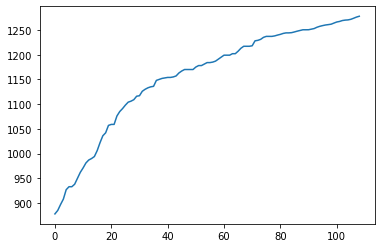

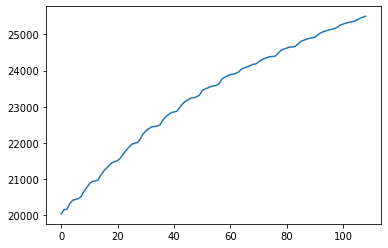

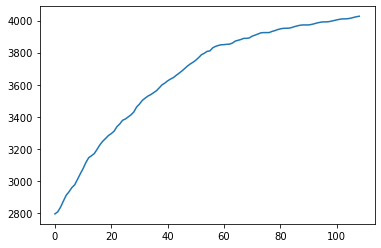

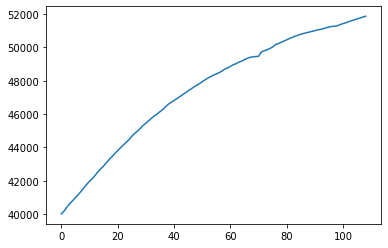

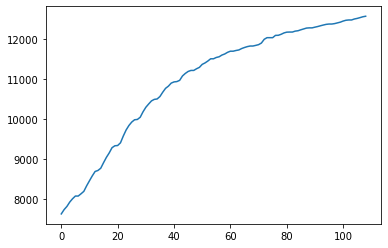

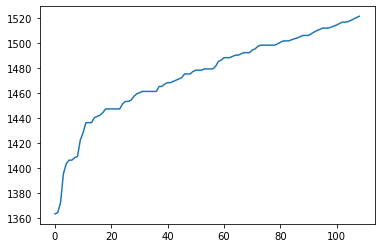

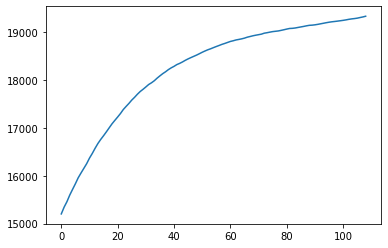

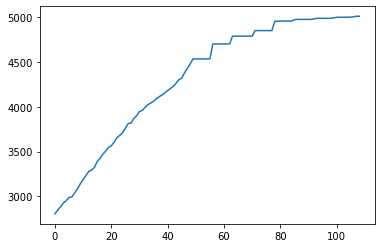

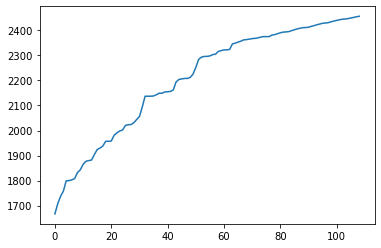

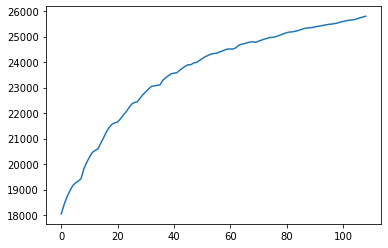

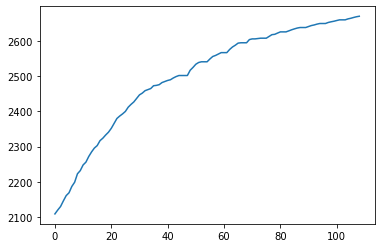

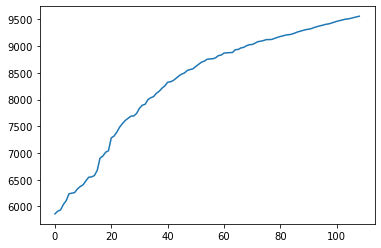

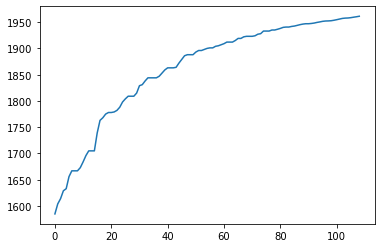

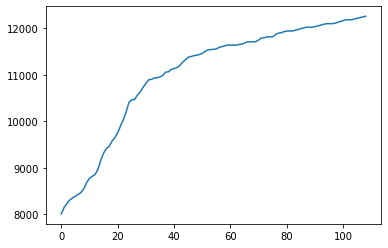

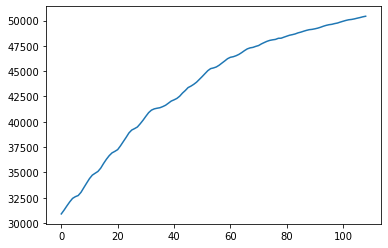

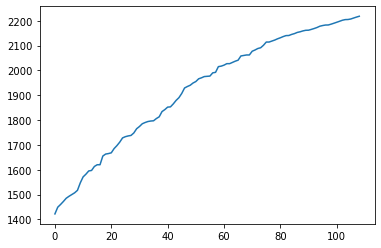

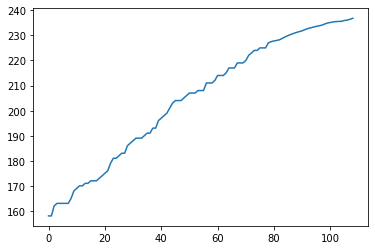

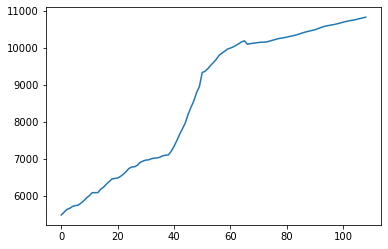

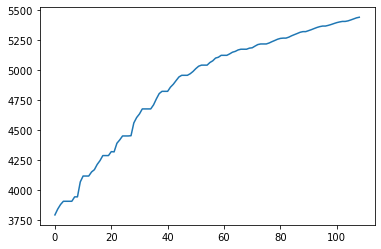

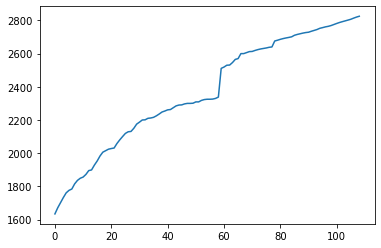

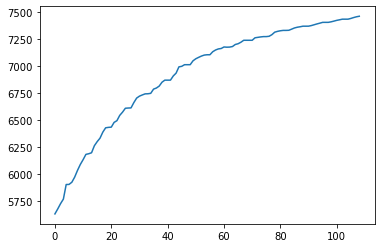

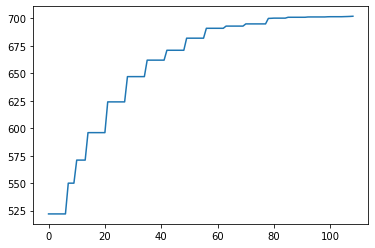

In [26]:
import matplotlib.pyplot as plt

for state in prediction["State"].cat.categories:
    values = prediction.loc[prediction.State == state, "Deaths"].values
    plt.figure()
    plt.plot(values)

In [27]:
prediction["Confirmed"].iloc[3950:5450]

0       5.158783e+05
1       6.306162e+04
2       8.424936e+05
3       3.306907e+05
4       3.671258e+06
            ...     
1495    6.631889e+05
1496    4.064792e+05
1497    1.530620e+05
1498    6.604313e+05
1499    5.878954e+04
Name: Confirmed, Length: 1500, dtype: float64

In [28]:
submission

,ID,Confirmed,Deaths
0,0,-1,-1
1,1,-1,-1
2,2,-1,-1
3,3,-1,-1
4,4,-1,-1
...,...,...,...
1495,1495,-1,-1
1496,1496,-1,-1
1497,1497,-1,-1
1498,1498,-1,-1


In [29]:
submission["Confirmed"] = prediction["Confirmed"].iloc[3950:5450]

In [30]:
submission["Deaths"] = prediction["Deaths"].iloc[3950:5450]

In [31]:
submission

,ID,Confirmed,Deaths
0,0,5.158783e+05,10565.469346
1,1,6.306162e+04,313.328368
2,2,8.424936e+05,16986.917296
3,3,3.306907e+05,5635.958723
4,4,3.671258e+06,59454.347174
...,...,...,...
1495,1495,6.631889e+05,10819.193918
1496,1496,4.064792e+05,5441.310241
1497,1497,1.530620e+05,2825.132489
1498,1498,6.604313e+05,7462.431666


In [32]:
train_trendency.isnull().any()

Date         False
Confirmed    False
Deaths       False
State        False
dtype: bool

In [33]:
submission.to_csv('working/submission.csv', index=False)

In [35]:
!head working/submission.csv

ID,Confirmed,Deaths
0,515878.30477107095,10565.469346058653
1,63061.62166557675,313.3283682688348
2,842493.6345713823,16986.917295825708
3,330690.6988353633,5635.958723306406
4,3671258.1348740486,59454.34717359317
5,463416.5896777862,6111.256173686182
6,311903.38977235655,7893.4137515204175
7,95018.19117253163,1561.1468103452955
8,2063739.3002749723,33507.464591746866
